In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from datetime import date
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns


In [2]:
data = pd.read_csv('/content/drive/MyDrive/hyundai.csv',parse_dates=['Date'])
data2 = pd.read_csv('/content/drive/MyDrive/hyundai2.csv',parse_dates=['Date'])

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,236500.0,238000.0,224500.0,224500.0,187513.859375,720748.0
1,2014-01-03,226500.0,228000.0,222500.0,224000.0,187096.234375,572466.0
2,2014-01-06,224000.0,231000.0,222500.0,228500.0,190854.828125,669198.0
3,2014-01-07,232000.0,232000.0,228500.0,229000.0,191272.468750,464556.0
4,2014-01-08,230000.0,231500.0,228500.0,229500.0,191690.093750,242741.0


In [3]:
data['year']=data['Date'].dt.year
data['month']=data['Date'].dt.month
data['day']=data['Date'].dt.day
data['mid'] = (data.High+ data.Low) / 2

data2['year']=data2['Date'].dt.year
data2['month']=data2['Date'].dt.month
data2['day']=data2['Date'].dt.day
data2['mid'] = (data2.High+ data2.Low) / 2



data.head() ,data.shape

(        Date      Open      High       Low  ...  year  month  day       mid
 0 2014-01-02  236500.0  238000.0  224500.0  ...  2014      1    2  231250.0
 1 2014-01-03  226500.0  228000.0  222500.0  ...  2014      1    3  225250.0
 2 2014-01-06  224000.0  231000.0  222500.0  ...  2014      1    6  226750.0
 3 2014-01-07  232000.0  232000.0  228500.0  ...  2014      1    7  230250.0
 4 2014-01-08  230000.0  231500.0  228500.0  ...  2014      1    8  230000.0
 
 [5 rows x 11 columns], (1719, 11))

In [4]:
data.dropna(axis=0,inplace=True)
data.isnull().sum()
data.reset_index(drop=True,inplace=True)
data['weekday']=data['Date'].dt.weekday

data2.dropna(axis=0,inplace=True)
data2.isnull().sum()
data2.reset_index(drop=True,inplace=True)
data2['weekday']=data2['Date'].dt.weekday


data.head() ,data.shape

(        Date      Open      High       Low  ...  month  day       mid  weekday
 0 2014-01-02  236500.0  238000.0  224500.0  ...      1    2  231250.0        3
 1 2014-01-03  226500.0  228000.0  222500.0  ...      1    3  225250.0        4
 2 2014-01-06  224000.0  231000.0  222500.0  ...      1    6  226750.0        0
 3 2014-01-07  232000.0  232000.0  228500.0  ...      1    7  230250.0        1
 4 2014-01-08  230000.0  231500.0  228500.0  ...      1    8  230000.0        2
 
 [5 rows x 12 columns], (1714, 12))

In [5]:
target=pd.DataFrame()
target['tomorrow']=data.Open[1:]
target.reset_index(drop=True,inplace=True)

real_target=pd.DataFrame()
real_target['tomorrow']=data2.Open[1:]
real_target.reset_index(drop=True,inplace=True)


target.head()

,tomorrow
0,226500.0
1,224000.0
2,232000.0
3,230000.0
4,228500.0


In [6]:
full_data=pd.concat([data,target],join='inner',axis=1)
full_data['changing']=((full_data.tomorrow-full_data.Open)/full_data.Open)*100
full_data.head()


full_data2=pd.concat([data2,real_target],join='inner',axis=1)
full_data2['changing']=((full_data2.tomorrow-full_data2.Open)/full_data2.Open)*100


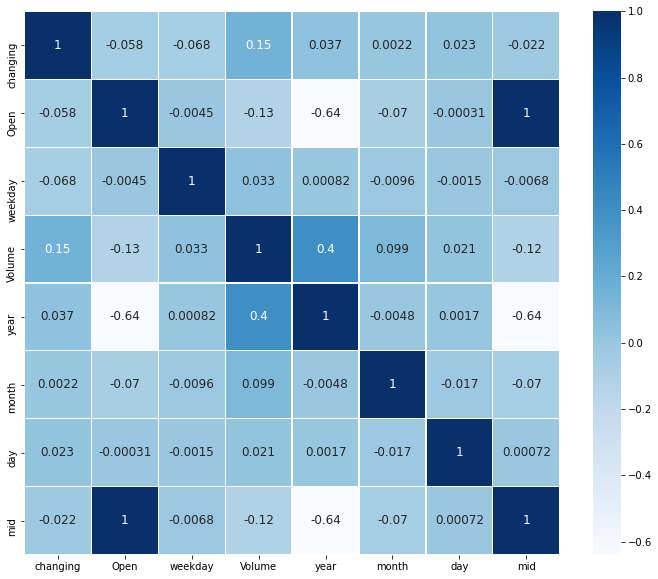

In [9]:
heat_data=full_data[['changing','Open','weekday','Volume','year','month','day','mid']]
plt.figure(figsize=(12,10))
sns.heatmap(heat_data.astype(float).corr(),linewidths=0.1,vmax=1.0,annot=True,annot_kws={'size':12},cmap='Blues')

In [10]:
train1=full_data.drop(['day','Date','Adj Close','changing','tomorrow','year','month'],axis=1)
target1=full_data['changing']


real_train1=full_data2.drop(['day','Date','Adj Close','changing','tomorrow','year','month'],axis=1)
real_target1=full_data2['changing']

In [11]:
k= int(round(train1.shape[0]*0.7))
train1.head(),k

(       Open      High       Low     Close    Volume       mid  weekday
 0  236500.0  238000.0  224500.0  224500.0  720748.0  231250.0        3
 1  226500.0  228000.0  222500.0  224000.0  572466.0  225250.0        4
 2  224000.0  231000.0  222500.0  228500.0  669198.0  226750.0        0
 3  232000.0  232000.0  228500.0  229000.0  464556.0  230250.0        1
 4  230000.0  231500.0  228500.0  229500.0  242741.0  230000.0        2, 1199)

In [12]:
real_train1.head()

,Open,High,Low,Close,Volume,mid,weekday
0,194000.0,211000.0,193500.0,207500.0,5651695,202250.0,0
1,207000.0,213000.0,205000.0,209500.0,3022595,209000.0,1
2,209500.0,211500.0,202500.0,203000.0,2848547,207000.0,2
3,206000.0,210500.0,204500.0,206000.0,2478337,207500.0,3
4,240500.0,257000.0,225000.0,246000.0,19933702,241000.0,4


In [13]:
train2=train1[:k]
target2=target1[:k]
train3=train1[k:]
target3=target1[k:]



In [14]:
train_input,test_input,train_target,test_target = train_test_split(train2,target2,test_size=0.7)
model = LinearRegression()

In [15]:
model.fit(train_input,train_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

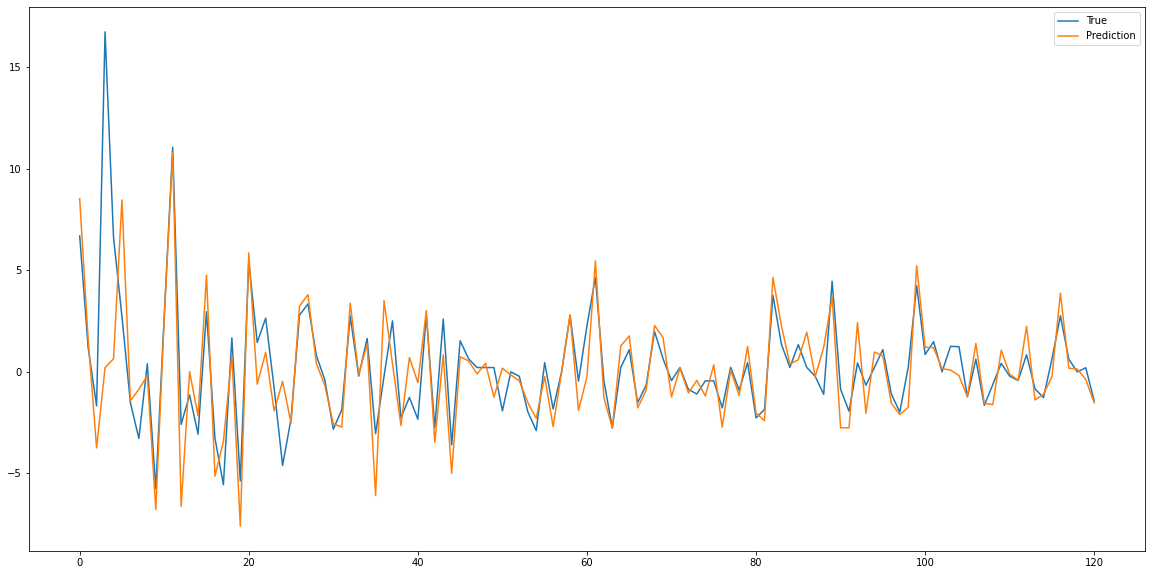

In [16]:

# plt.show()
# test_out2=test_out.reset_index(drop=True,inplace=True)
# test_out2
# test_input2=test_input.reset_index(drop=True,inplace=True)
# test_input2
# test_target.reset_index(drop=True,inplace=True)
target3.reset_index(drop=True,inplace=True)

pred = model.predict(real_train1)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(real_target1, label='True')
ax.plot(pred, label='Prediction')
# plt.xlim(200,300)
ax.legend()
plt.show()

In [27]:
real_price=np.round(real_train1['Close']+real_train1['Close']*real_target1/100)

pred_price=np.round(real_train1['Close']+real_train1['Close']*pred/100)
real_price , pred_price

(0      221405.0
 1      212030.0
 2      199609.0
 3      240500.0
 4      262366.0
          ...   
 116    247652.0
 117    244003.0
 118    242500.0
 119    243499.0
 120    237543.0
 Length: 121, dtype: float64, 0      225203.0
 1      212925.0
 2      195401.0
 3      206435.0
 4      247581.0
          ...   
 116    250337.0
 117    242941.0
 118    242847.0
 119    242086.0
 120    237331.0
 Name: Close, Length: 121, dtype: float64)

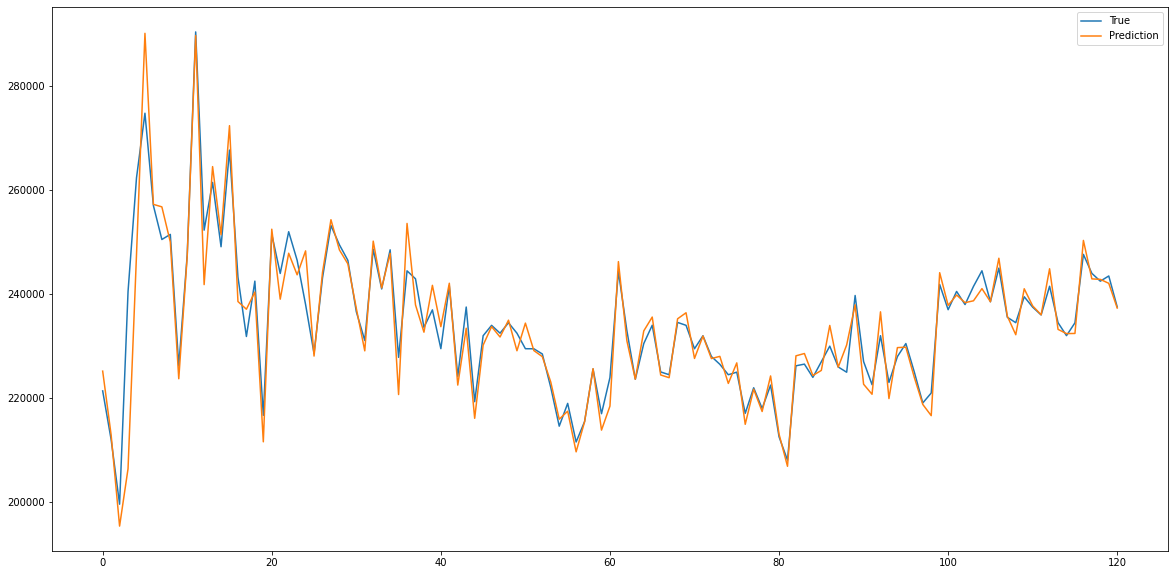

In [28]:
f,ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(real_price, label='True')
ax.plot(pred_price, label='Prediction')
# plt.xlim(200,300)
ax.legend()
plt.show()

In [ ]:
pred.shape , pred[1]

((121,), 3.5892526769424693)

In [ ]:
# 1.5%이상 상승예측인 날만 투자했을경우 세금과 수수료제외하고 원금의 몇%오르는지
success=1
for i in range(pred.shape[0]):
  if float(pred[i])<=0 and float(real_target1[i])<=0:
    success=success+0 
  elif float(pred[i])>1.5:
    success= success*(1+(real_target1[i]-0.5)/100)     
#   # elif float(pred[i])>0 and float(test_target[i])>0: 
#     # success+=
# # print(success/pred.shape[0])*100)
print(success)

2.1695957982844587


In [ ]:
# 평균 오차 %
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(pred,real_target1)
mae

1.4101463477563012

In [ ]:
#다음날 주가예상
data3_t=pd.read_csv('/content/drive/MyDrive/tohy.csv')
data3_t.head()

,Open,High,Low,Close,Volume,mid,weekday
0,238500,243000,236000,242000,1013542,239500,3


In [ ]:
# 모델 가중치보기
tohy=model.predict(data3_t)
tohy, np.round(model.coef_,decimals=4)

(array([2.38891214]),
 array([-0.0007,  0.0001,  0.0001,  0.0005,  0.    ,  0.0001, -0.0797]))

In [ ]:
data0=data.dropna(axis=0)
data0.reset_index(drop=True,inplace=True)
data0.isnull().sum(), data0.shape

(Date         0
 Open         0
 High         0
 Low          0
 Close        0
 Adj Close    0
 Volume       0
 mid          0
 dtype: int64, (1323, 8))

In [ ]:
bb

In [ ]:
target=pd.DataFrame()
target['tomorrow']=data0.Open[1:]
target.reset_index(drop=True,inplace=True)
# target1=target.dropna(axis=0)
# target2 = target.reset_index()
target , target.shape

(      tomorrow
 0      23040.0
 1      23220.0
 2      23000.0
 3      23000.0
 4      23120.0
 ...        ...
 1317   80500.0
 1318   80400.0
 1319   81500.0
 1320   81700.0
 1321   81900.0
 
 [1322 rows x 1 columns], (1322, 1))

In [ ]:
target.tail(), input.tail()

(      tomorrow
 1317   80500.0
 1318   80400.0
 1319   81500.0
 1320   81700.0
 1321   81900.0,
             Date     Open     High  ...  Adj Close      Volume      mid
 1322  2021-06-22  80200.0  80300.0  ...    80000.0  11773365.0  80100.0
 1323  2021-06-23  80500.0  80600.0  ...    80100.0  13856548.0  80250.0
 1324  2021-06-24  80400.0  81400.0  ...    81200.0  18771080.0  80750.0
 1325  2021-06-25  81500.0  81900.0  ...    81600.0  13481405.0  81550.0
 1326  2021-06-28  81700.0  82000.0  ...    81900.0  11578529.0  81800.0
 
 [5 rows x 8 columns])

In [ ]:

indata= pd.concat([data0,target['tomorrow']],join='inner',axis=1)
indata['changing']= ((indata.tomorrow-indata.Open)/indata.Open)*100
indata.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume,mid,tomorrow,changing
1312,2021-06-15,80900.0,81200.0,80600.0,80900.0,80900.0,10075685.0,80900.0,81500.0,0.741656
1313,2021-06-16,81500.0,81900.0,81100.0,81800.0,81800.0,14999855.0,81500.0,81100.0,-0.490798
1314,2021-06-17,81100.0,81300.0,80700.0,80900.0,80900.0,14007385.0,81000.0,81100.0,0.000000
1315,2021-06-18,81100.0,81100.0,80500.0,80500.0,80500.0,14916721.0,80800.0,79700.0,-1.726264
1316,2021-06-21,79700.0,80000.0,79600.0,79900.0,79900.0,16063340.0,79800.0,80200.0,0.627353
1317,2021-06-22,80200.0,80300.0,79900.0,80000.0,80000.0,11773365.0,80100.0,80500.0,0.374065
1318,2021-06-23,80500.0,80600.0,79900.0,80100.0,80100.0,13856548.0,80250.0,80400.0,-0.124224
1319,2021-06-24,80400.0,81400.0,80100.0,81200.0,81200.0,18771080.0,80750.0,81500.0,1.368159
1320,2021-06-25,81500.0,81900.0,81200.0,81600.0,81600.0,13481405.0,81550.0,81700.0,0.245399
1321,2021-06-28,81700.0,82000.0,81600.0,81900.0,81900.0,11578529.0,81800.0,81900.0,0.244798


In [ ]:
spl_num = int(round(indata.shape[0]*0.7))
spl_num
indata.drop(['Date','tomorrow'],axis=1,inplace=True)

In [ ]:
train_data = indata[:spl_num]
test_data=indata[spl_num:]
train_data.head()


rtest_in=test_data[test_data.columns[:7]]
rtest_out=test_data[test_data.columns[7:]]
rtest_in.head()


,Open,High,Low,Close,Adj Close,Volume,mid
925,53400.0,53400.0,52000.0,52000.0,49175.296875,12560070.0,52700.0
926,51600.0,52100.0,50600.0,51000.0,48229.621094,14298646.0,51350.0
927,51000.0,51600.0,50900.0,51600.0,48797.023438,8478310.0,51250.0
928,52200.0,52600.0,51700.0,51800.0,48986.164063,9050625.0,52150.0
929,51900.0,52900.0,51800.0,51800.0,48986.164063,27372226.0,52350.0


In [ ]:
train,test = train_test_split(train_data,test_size=0.5)
train_input=train[train.columns[:7]]
train_out=train[train.columns[7:]]

test_input=test[test.columns[:7]]
test_out=test[test.columns[7:]]



train_input.head() ,train_out.head()


(        Open     High      Low    Close     Adj Close      Volume      mid
 246  39900.0  39900.0  39460.0  39460.0  34714.449219  17992200.0  39680.0
 124  31360.0  31360.0  30920.0  30960.0  26820.328125   8315800.0  31140.0
 666  41400.0  43000.0  41000.0  42350.0  38784.027344  14205190.0  42000.0
 128  31320.0  31500.0  31120.0  31380.0  27184.169922  11125150.0  31310.0
 629  47100.0  48450.0  47000.0  48450.0  44039.015625  13577454.0  47725.0,
      changing
 246 -0.902256
 124 -1.275510
 666  3.623188
 128  0.510856
 629  2.335456)

In [ ]:
model= LinearRegression()
model.fit(train_input,train_out)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

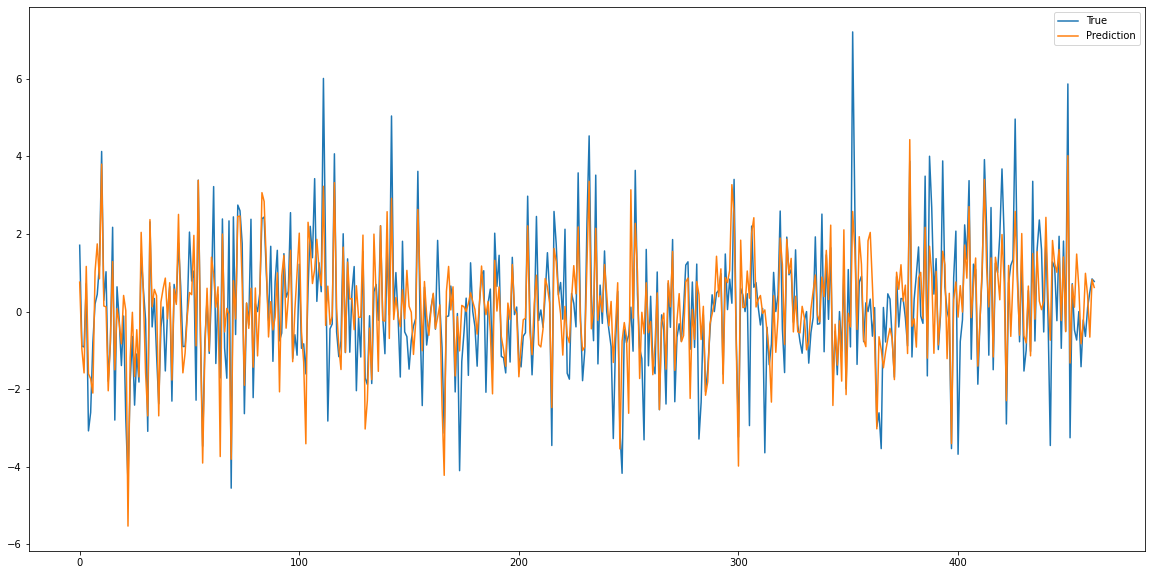

In [ ]:
# pred = model.predict(test_input)

# model.score(test_input,test_out)
# plt.plot(test_out)
# plt.plot(pred)

plt.show()
test_out2=test_out.reset_index(drop=True,inplace=True)
test_out2
test_input2=test_input.reset_index(drop=True,inplace=True)
test_input2


pred = model.predict(test_input)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(test_out, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

In [ ]:
pred2=pd.DataFrame(pred)
pred2 , test_out

(            0
 0    0.758755
 1   -0.969032
 2   -1.581429
 3    1.164594
 4   -1.605867
 ..        ...
 458  0.986892
 459  0.410715
 460 -0.658492
 461  0.822997
 462  0.621563
 
 [463 rows x 1 columns],      changing
 0    1.710526
 1   -0.889077
 2   -0.912201
 3    0.721154
 4   -3.076923
 ..        ...
 458 -0.640342
 459  0.108499
 460  0.500000
 461  0.842223
 462  0.776915
 
 [463 rows x 1 columns])

In [ ]:
test_out.loc[1,['changing']]

changing   -0.889077
Name: 1, dtype: float64

In [ ]:
success=0
for i in range(463):
  if float(pred2.loc[i])<=0 and float(test_out.loc[i,['changing']])<=0: 
    success+=1
  elif float(pred2.loc[i])>0 and float(test_out.loc[i])>0: 
    success+=1
print((success/463)*100)

80.56155507559394


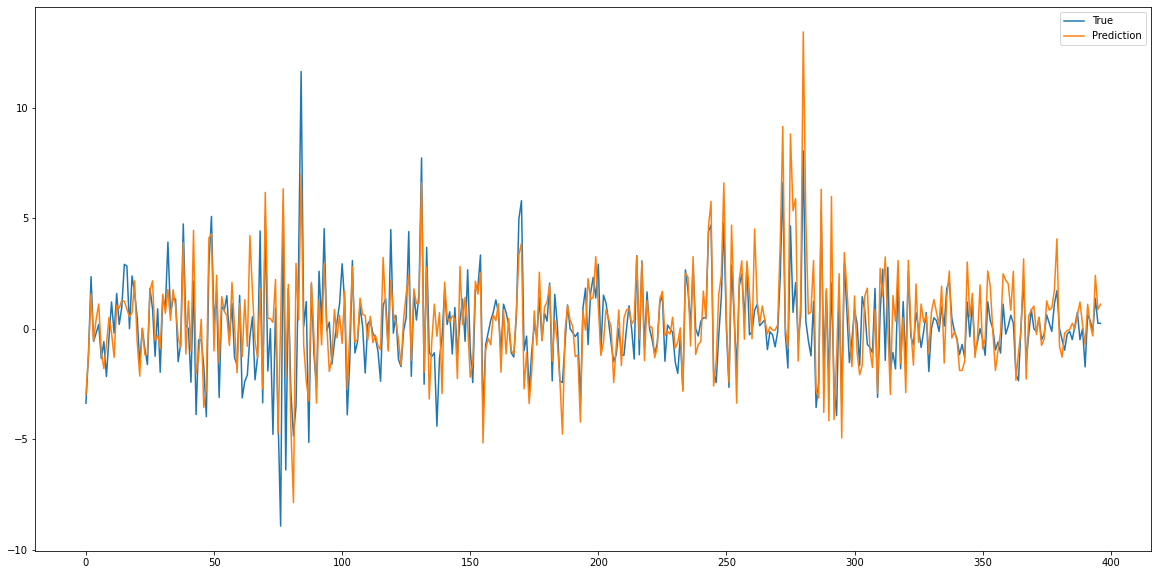

In [ ]:
pred = model.predict(rtest_in)
rtest_out.reset_index(drop=True,inplace=True)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(rtest_out, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

In [ ]:
rtest_out

,changing
0,-3.370787
1,-1.162791
2,2.352941
3,-0.574713
4,-0.192678
...,...
392,0.374065
393,-0.124224
394,1.368159
395,0.245399


In [ ]:
pred7=pd.DataFrame(pred)
success=0
for i in range(396):
  if float(pred7.loc[i])<=0 and float(rtest_out.loc[i,['changing']])<=0: 
    success+=1
  elif float(pred7.loc[i])>0 and float(rtest_out.loc[i])>0: 
    success+=1
print((success/396)*100)

77.77777777777779
